## Import Packages
Import packages yang perlukan dalam project capstone ini


In [3]:
# import packages
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import ibm_boto3
from ibm_botocore.client import Config, ClientError
import io

## Import Dataset

Mendownload dataset yang akan digunakan, dalam kesempatan ini diambil dari website Kaggle.

In [ ]:
# Akses dataset dari Website Kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"awanama","key":"ecbb4ae94ebce1fbc35b533617f5b4d6"}

import json

with open('/home/wsuser/work/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /home/wsuser/.kaggle/kaggle.json

In [ ]:
!pip -q install kaggle
import kaggle

In [ ]:
!kaggle datasets download -q -d kmirfan/micro-expressions

In [ ]:
!unzip -q '/home/wsuser/work/micro-expressions.zip'

## Generate Dataset

Menentukan path data train dan validation, kemudian gunakan ImageDataGenerator terhadap data train dan data validation.

In [4]:
# menentukan direktori dataset training dan validation
train_dir = '/home/wsuser/work/Micro_Expressions/train'
valid_dir = '/home/wsuser/work/Micro_Expressions/test'

# menentukan ukuran gambar
img_width, img_height, channel = (224, 224, 3)

# gunakan ImageDataGenerator pada data train dan validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = 64,
    class_mode = 'categorical'
)

Found 7600 images belonging to 7 classes.


In [5]:
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (img_width, img_height),
    batch_size = 64,
    class_mode = 'categorical'
)

Found 1860 images belonging to 7 classes.


In [ ]:
classes = train_data.class_indices
classes

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'happiness': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

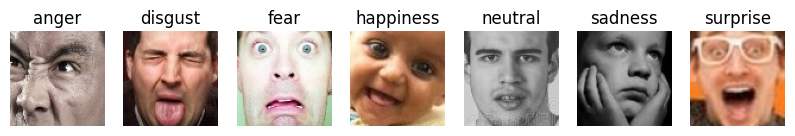

In [ ]:
# melihat salah satu gambar dari tiap kelas
def display_images_from_each_class(class_folder_path):
    fig, axs = plt.subplots(1, len(os.listdir(class_folder_path)), figsize=(10, 4))

    for i, class_name in enumerate(sorted(os.listdir(class_folder_path))):
        class_path = os.path.join(class_folder_path, class_name)
        img_files = os.listdir(class_path)

        # Randomly select an image from the class folder
        img_file = random.choice(img_files)
        img_path = os.path.join(class_path, img_file)

        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(class_name)

    plt.show()

class_folder = '/home/wsuser/work/Micro_Expressions/train'
display_images_from_each_class(class_folder)

## Membuat Model

Pembuatan model menggunakan pretrained model MobileNetV3-Large. <br>
Kemudian memberi tambahan pada arsitektur model dengan menyesuaikan kondisi dataset.

In [ ]:
# membuat model dasar
from tensorflow.keras.applications import MobileNetV3Large

base_model = MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    classes=7,
    input_shape=(224, 224, 3)
)

# membekukan layer
for layer in base_model.layers[:-10]:
    layer.trainable = False

base_model.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)        

In [ ]:
# menambahkan beberapa layer menyesuaikan dataset
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(7, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                  

## Compile Model
Menentukan optimizer, loss, dan metric yang akan ditampilkan saat training.

In [ ]:
# membuat compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Membuat Callback

Membuat callback agar dapat digunakan pada saat training model untuk mempermudah pemantauan proses training.

In [ ]:
# membuat callback
checkpoint = ModelCheckpoint(filepath="deteksi_emosi.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

## Membuat Fit Model

Menentukan epoch, callback, dan verbose untuk proses training.

In [ ]:
# membuat fit model
history = model.fit(
    train_data,
    validation_data = valid_data,
    epochs = 100,
    callbacks = [callbacks_list],
    verbose = 1
)

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 1.0670 - accuracy: 0.6204
Epoch 1: val_accuracy improved from -inf to 0.66452, saving model to best_model.h5
119/119 [==============================] - 119s 931ms/step - loss: 1.0670 - accuracy: 0.6204 - val_loss: 0.9544 - val_accuracy: 0.6645 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.8266 - accuracy: 0.7034
Epoch 2: val_accuracy did not improve from 0.66452
119/119 [==============================] - 112s 939ms/step - loss: 0.8266 - accuracy: 0.7034 - val_loss: 1.0152 - val_accuracy: 0.6516 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.7372
Epoch 3: val_accuracy did not improve from 0.66452
119/119 [==============================] - 110s 927ms/step - loss: 0.7435 - accuracy: 0.7372 - val_loss: 1.0603 - val_accuracy: 0.6339 - lr: 0.0010
Epoch 4/100
119/119 [==============================] - ETA: 0s - loss: 0.6923 - 

## Evaluasi

Melakukan evaluasi pada hasil training dengan menampilkan metric dan juga grafik loss dan accuracy dari proses training.

In [ ]:
# evaluasi hasil model
model.evaluate(valid_data)

30/30 [==============================] - 6s 213ms/step - loss: 0.6664 - accuracy: 0.7887


[0.6664485335350037, 0.7887097001075745]

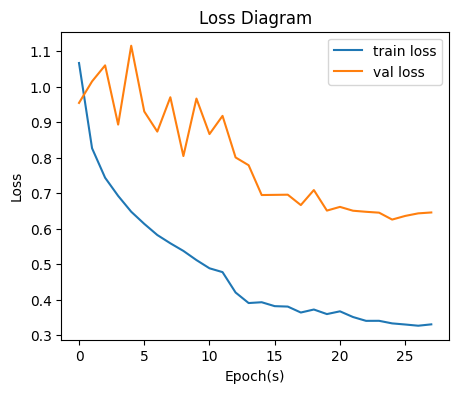

In [ ]:
# diagram loss selama training
plt.figure(figsize=(5, 4))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

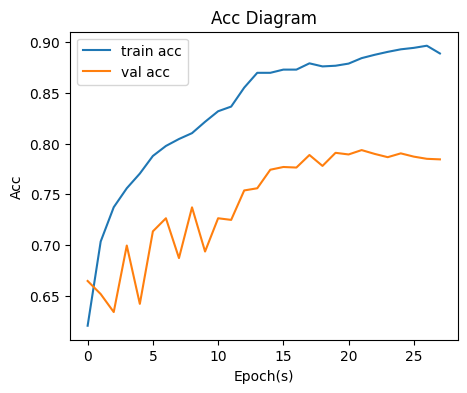

In [ ]:
# diagram akurasi selama training
plt.figure(figsize=(5, 4))
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.legend(['train acc', 'val acc'])
plt.title('Acc Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Acc')
plt.show()

# Simpan Model

Menyimpan model yang telah ditraining.

In [ ]:
# simpan model
model.save('deteksi_emosi.h5')

## Load Model dan Jalankan Model

Menggunakan hasil model yang sudah ditraining dan di-load untuk testing.

In [ ]:
# load model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

path_model_save = '/home/wsuser/work/deteksi_emosi.h5'
loaded_model = load_model(path_model_save)

## Membuat Prediksi
Menguji model yang telah ditraining sebelumnya dengan data yang belum pernah dijumpai.

In [ ]:
# mendownload gambar secara acak di internet
!wget -q "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRS5L6gyc56CblvgRyzQ_C4POMbm4uwK1Q9tQ&usqp=CAU" -O test.jpg

1/1 [==============================] - 0s 26ms/step


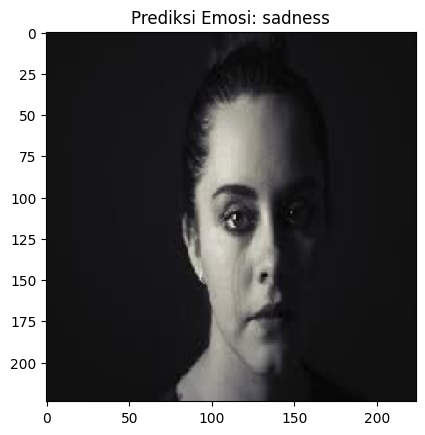

Probabilitas anger: 0.0069
Probabilitas disgust: 0.0001
Probabilitas fear: 0.0008
Probabilitas happiness: 0.0162
Probabilitas neutral: 0.0351
Probabilitas sadness: 0.9409
Probabilitas surprise: 0.0000


In [ ]:
# Load dan preprocessing gambar
path = "test.jpg"
img = image.load_img(path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Buat prediksi
predictions = loaded_model.predict(x)

# Mencari label dengan probabilitas tertinggi
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
predicted_label = emotion_labels[np.argmax(predictions)]
predicted_prob = predictions[0]

# Menampilkan gambar dan prediksi emosi
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f'Prediksi Emosi: {predicted_label}')
plt.show()

# Menampilkan hasil prediksi tiap label
for label, prob in zip(emotion_labels, predicted_prob):
    print(f'Probabilitas {label}: {prob:.4f}')


# Rekomendasi Musik

Membuat beberapa rekomendasi musik berdasarkan hasil prediksi emosi.

In [ ]:
# Mengunduh dataset 
!kaggle datasets download -d musicblogger/spotify-music-data-to-identify-the-moods

In [ ]:
!unzip -q '/home/wsuser/work/spotify-music-data-to-identify-the-moods.zip'

In [ ]:
mood_music = pd.read_csv("data_moods.csv")
mood_music.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [ ]:
mood_music = mood_music[['name', 'artist', 'popularity', 'length', 'mood']]
mood_music.head()

,name,artist,popularity,length,mood
0,1999,Prince,68,379266,Happy
1,23,Blonde Redhead,43,318800,Sad
2,9 Crimes,Damien Rice,60,217946,Sad
3,99 Luftballons,Nena,2,233000,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,60,268000,Energetic


In [ ]:
mood_music["mood"].value_counts()

Sad          197
Calm         195
Energetic    154
Happy        140
Name: mood, dtype: int64

In [ ]:
# Mengambil lima data secara random berkaitan label 'Sad' 
play = mood_music[mood_music['mood'] == 'Sad']
play_top_5 = play.sample(n=min(5, len(play)), random_state=42)
display(play_top_5)

,name,artist,popularity,length,mood
522,Summer-Blink,Cocteau Twins,22,189653,Sad
422,Play The Ghost,Sarah Davachi,31,301291,Sad
55,Before You Go,Lewis Capaldi,85,215106,Sad
280,Jupiter 4,Sharon Van Etten,39,314080,Sad
561,The Night We Met,Lord Huron,17,208211,Sad


In [ ]:
# Fungsi untuk merekomendasikan mood lagu berdasarkan emosi
def recommend_songs(pred_class):
    if pred_class in ['Disgust', 'Sad']:
        mood = 'Sad'  
    elif pred_class == 'Happy':
        mood = 'Happy'  
    elif pred_class in ['Fear', 'Angry']:
        mood = 'Calm'  
    elif pred_class in ['Surprise', 'Neutral']:
        mood = 'Energetic'  
    else:
        return None  
    
    # Memfilter lagu berdasarkan mood
    recommended_songs = mood_music[mood_music['mood'] == mood]

    # Jika tidak ada lagu untuk mood yang diprediksi, rekomendasikan lagu acak dari semua mood
    if recommended_songs.empty:
        recommended_songs = mood_music.sample(frac=1).reset_index(drop=True)

    recommended_songs = recommended_songs.head(5)  # Ambil 5 lagu teratas
    return recommended_songs  


In [ ]:
# Mengunduh gambar secara acak di internet
!wget -q "https://media.gettyimages.com/id/1214069040/photo/sad-young-man-in-a-white-t-shirt-with-emotions-and-sadness-and-on-his-face.jpg?s=612x612&w=gi&k=20&c=NR1AS93-aArqOQKrXNXetF6mQOYDOzb4wHFpP2vIFeE=" -O test2.jpg

1/1 [==============================] - 0s 53ms/step


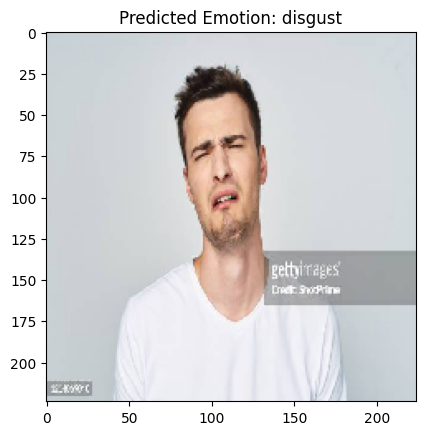

Probability for anger: 0.0105
Probability for disgust: 0.9007
Probability for fear: 0.0089
Probability for happiness: 0.0606
Probability for neutral: 0.0008
Probability for sadness: 0.0151
Probability for surprise: 0.0035

Recommended Songs for disgust: 
           name                    artist  popularity  length mood
1            23            Blonde Redhead          43  318800  Sad
2      9 Crimes               Damien Rice          60  217946  Sad
17  Algo Rhythm  One Sentence. Supervisor           0  210626  Sad
18       Alison                  Slowdive           0  231893  Sad
20   All I Want                  Kodaline          29  306600  Sad


In [ ]:
# Load dan preprocesing gambar
path = "test2.jpg"
img = image.load_img(path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Membuat prediksi
predictions = loaded_model.predict(x)

# Mengambil label emosi dengan probabilitas tertinggi
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
predicted_label = emotion_labels[np.argmax(predictions)]
predicted_prob = predictions[0]

# Menampilkan gambar dan prediksi emosi
plt.imshow(img)
plt.title(f'Predicted Emotion: {predicted_label}')
plt.show()

# Menampilkan probabilitas emosi di tiap kelas
for label, prob in zip(emotion_labels, predicted_prob):
    print(f'Probability for {label}: {prob:.4f}')

# Menampilkan rekomendasi lagu berdasarkan prediksi emosi
print(f'\nRecommended Songs for {predicted_label}: \n{recommended_songs}')


## Save Model
Menyimpan model dengan cara khusus di Jupyter Notebook IBM Watson Studio

In [ ]:
# Informasi terkait Cloud Object Storage
cos_credentials = {"apikey": "wdYI9WrT2jOHMd553uHjQHbnMo3Hvo1XJN2s_jKiu51r",
                    "cos_hmac_keys": {
                                        "access_key_id": "4c92e1b444434c3083d3dd06da5de504",
                                        "secret_access_key": "1629efc8998634162512a4a57c1d3996221605b02e86c3a5"},
                    "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
                    "iam_apikey_description": "Auto-generated for key crn:v1:bluemix:public:cloud-object-storage:global:a/87db1fee54ca4d57967b00f8d5e45bee:eea29157-7a0f-4822-990c-2ca05c765a3d:resource-key:4c92e1b4-4443-4c30-83d3-dd06da5de504",
                    "iam_apikey_name": "WDP-Editor-projectcapstonehcai-donotdelete-pr-4byjpktki2natp",
                    "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
                    "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/87db1fee54ca4d57967b00f8d5e45bee::serviceid:ServiceId-d9369761-ab79-4631-9997-47844155b109",
                    "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/87db1fee54ca4d57967b00f8d5e45bee:eea29157-7a0f-4822-990c-2ca05c765a3d::"
}

auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://s3.private.us-south.cloud-object-storage.appdomain.cloud'

In [ ]:
# Buat client
cos = ibm_boto3.client('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                        ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

In [ ]:
# Fungsi untuk upload file ke Cloud Object Storage
def upload_file(file_name, bucket, object_name=None):
    if object_name is None:
        object_name = os.path.basename(file_name)
    s3_client = cos
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [ ]:
# Upload file model ke Cloud Object Storage
upload_file('./deteksi_emosi.h5','projectcapstonehcai-donotdelete-pr-4byjpktki2natp')